In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Program name

AS_LevAlternation

### Variable Definitions

- E   = event identity stamp
- T   = event time stamp

### Event Stamps

#### Trial bits
- 5   - Reversal of rewarded lever
- 6   - ITI starts
- 7   - ITI ends
- 10  - Right lever extends #left happens at same time
- 12  - Right lever retracts #left happens at same time


#### Non-ITI bits
- 1   - Right lever press
- 2   - Left lever press
- 3   - Head entry in food tray
- 4   - Pellet delivery

#### ITI bits


#### remainder 

- 8   - Right lever becomes active
- 9   - Left lever becomes active
- 11  - Left lever extends
- 13  - Left lever retracts
- 100 - End of session marker


In [2]:
def get_file_info_common(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        elif re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        else:
            i = i + 1

    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_LPDS(events_and_times, trial_start, trial_end, ITI_start, ITI_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. session onset and offset, ITI onset and offset - here both levers extend so can just use right lever as start
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    session_start_times = list(events_and_times[events_and_times['event_stamp'] == trial_start]['time_stamp'].values)
    session_end_times = list(events_and_times[events_and_times['event_stamp'] == trial_end]['time_stamp'].values)
    ITI_start_times = list(events_and_times[events_and_times['event_stamp'] == ITI_start]['time_stamp'].values + 0.01)
    ITI_end_times = list(events_and_times[events_and_times['event_stamp'] == ITI_end]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    ITI_start_times = ITI_start_times[1:] #drop first ITI (session starts with ITI)
    ITI_end_times = np.append(ITI_end_times[1:], session_end) #drop first ITI (session starts with ITI)
    
    times = pd.DataFrame(data = [session_start_times, session_end_times, ITI_start_times, ITI_end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    
    return times

In [6]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean()/100)
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [9]:
def create_session_df_LPDS(trial_data, event_dic, trial_type):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])/100
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    #add switch list and bin count
    switch_list = ['orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch',
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch', 
               'orig', 'orig', 'orig', 'orig', 'orig', 'switch', 'switch', 'switch', 'switch', 'switch']
    session_data['switch'] = switch_list[0:session_data.shape[0]]
    
    bin_list = [1,1,1,1,1,1,1,1,1,1,
               2,2,2,2,2,2,2,2,2,2,
               3,3,3,3,3,3,3,3,3,3,
               4,4,4,4,4,4,4,4,4,4,
               5,5,5,5,5,5,5,5,5,5,
               6,6,6,6,6,6,6,6,6,6,
               7,7,7,7,7,7,7,7,7,7,
               8,8,8,8,8,8,8,8,8,8,
               9,9,9,9,9,9,9,9,9,9]    
        
    session_data['trial_bin'] = bin_list[0:session_data.shape[0]]
    
    return session_data

### Read in animal meta data

In [10]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/2021April_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,animal,cage,group,lever
0,1215,SA319,4,right
1,1216,SA319,4,right
2,1217,SA319,4,right
3,1236,SA326,5,right
4,1237,SA326,5,right


### Get file paths

In [11]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

52
52


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_1_1224_210323'

### Process data

In [12]:
%%time
final_data = pd.DataFrame()

bit_dic = {'reinforcement': 4, 'right_lever': 1, 'left_lever': 2, 'HE': 3}
ITI_dic = {'reinforcement': 4, 'right_lever': 1, 'left_lever': 2, 'HE': 3}

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
    
    #proccess file
    task, session, animal, date = get_file_info_common(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E:", "T:")
    trial_times = get_trial_times_LPDS(events_and_times, 10,12,6,7,100)
    trial_data = create_trial_df(events_and_times, trial_times, 'within')
    ITItrial_data = create_trial_df(events_and_times, trial_times, 'ITI')
    session_data = create_session_df_LPDS(trial_data, bit_dic, 'within')
    ITIsession_data = create_session_df_LPDS(ITItrial_data, ITI_dic, 'ITI')
    
    #get animal metadata
    active_lever = animal_info[animal_info['animal'] == int(animal)]['lever'].iloc[0]
    group = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    cage = animal_info[animal_info['animal'] == int(animal)]['cage'].iloc[0]
    
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])
    session_data['part'] = ['within']*(session_data.shape[0]) 
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['active_lever'] = [active_lever]*(session_data.shape[0])
    session_data['group'] = [group]*(session_data.shape[0])
    session_data['cage'] = [cage]*(session_data.shape[0])
    
    session_data = session_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'switch', 'trial_num', 'trial_bin', 'trial_duration', 
                                 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'right_lever_latency_ave', 'left_lever_latency_ave']]
        
    #create pandas tidy df for within ITI
    ITIsession_data['task'] = [task]*(ITIsession_data.shape[0]) 
    ITIsession_data['part'] = ['ITI']*(ITIsession_data.shape[0]) 
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal'] = [animal]*(ITIsession_data.shape[0])
    ITIsession_data['session'] = [session]*(ITIsession_data.shape[0])
    ITIsession_data['active_lever'] = [active_lever]*(ITIsession_data.shape[0])
    ITIsession_data['group'] = [group]*(ITIsession_data.shape[0])
    ITIsession_data['cage'] = [cage]*(ITIsession_data.shape[0])
    
    ITIsession_data = ITIsession_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'switch', 'trial_num', 'trial_bin', 'trial_duration', 
                                 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'right_lever_latency_ave', 'left_lever_latency_ave']]

    #add to final data frame
    data_int = pd.concat([session_data, ITIsession_data], axis = 0, ignore_index=True)
    if final_data.shape[0] == 0:
        final_data = data_int
    else:
        final_data = pd.concat([final_data, data_int], axis = 0, ignore_index=True)

final_data.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_1_1224_210323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_1_1228_210323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_3_1219_210325
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_2_1243_210324
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_2_1232_210324
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS_3_1231_210325
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/.DS_Store
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round2/switch_lever/LPDS

,task,part,date,session,cage,animal,group,active_lever,switch,trial_num,trial_bin,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,right_lever_latency_ave,left_lever_latency_ave
5101,LPDS,ITI,210323,1,SA328,1242,5,right,orig,34,4,59.9899,0,NaN,7,0.5199,46.348471,0,NaN,0,NaN,NaN,NaN
5102,LPDS,ITI,210323,1,SA328,1242,5,right,switch,35,4,89.9899,0,NaN,2,2.6599,27.714900,0,NaN,0,NaN,NaN,NaN
5103,LPDS,ITI,210323,1,SA328,1242,5,right,switch,36,4,29.9899,0,NaN,2,2.8099,13.329900,0,NaN,0,NaN,NaN,NaN
5104,LPDS,ITI,210323,1,SA328,1242,5,right,switch,37,4,59.9899,0,NaN,1,2.6599,2.659900,0,NaN,0,NaN,NaN,NaN
5105,LPDS,ITI,210323,1,SA328,1242,5,right,switch,38,4,43.1799,0,NaN,4,2.1299,27.664900,0,NaN,0,NaN,NaN,NaN


In [13]:
#make new df with combined data
df_final = final_data.copy()

lp_train_df_trial = pd.DataFrame()

animals = df_final['animal'].unique()

for animal in animals:
    
    #get animal data
    animal_data = df_final[df_final['animal'] == animal]
    
    #generate session df
    sessions = animal_data['session'].unique()
    
    for session in sessions:
        #get session data for animal
        animal_data_session = animal_data[animal_data['session'] == session]
        
        #compute and fill session data
        if animal_data_session['active_lever'].unique() == 'right':
            animal_data_session['active_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']

        elif animal_data_session['active_lever'].unique() == 'left':
            animal_data_session['active_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            
        lp_train_df_trial = lp_train_df_trial.append(animal_data_session)
        
lp_train_df_trial.reset_index(inplace=True, drop=True)    

lp_train_df_trial = lp_train_df_trial[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                       'switch', 'trial_num', 'trial_bin', 'trial_duration',
                                       'reinforcement_count', 'reinforcement_latency_1st',
                                       'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                       'active_lever_count', 'active_lever_latency_1st',
                                       'inactive_lever_count', 'inactive_lever_latency_1st', 
                                       'active_lever_latency_ave', 'inactive_lever_latency_ave']]

lp_train_df_trial['lever_ratio'] = lp_train_df_trial['active_lever_count'] / (lp_train_df_trial['active_lever_count'] + lp_train_df_trial['inactive_lever_count'])

print(lp_train_df_trial.shape)
lp_train_df_trial.head()

(5106, 24)


,task,part,date,session,cage,animal,group,active_lever,switch,trial_num,trial_bin,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,active_lever_count,active_lever_latency_1st,inactive_lever_count,inactive_lever_latency_1st,active_lever_latency_ave,inactive_lever_latency_ave,lever_ratio
0,LPDS,within,210323,1,SA322,1224,4,right,orig,0,1,1.25,1,1.25,0,NaN,NaN,1,1.24,0,NaN,1.24,NaN,1.0
1,LPDS,within,210323,1,SA322,1224,4,right,orig,1,1,1.28,1,1.28,0,NaN,NaN,1,1.27,0,NaN,1.27,NaN,1.0
2,LPDS,within,210323,1,SA322,1224,4,right,orig,2,1,1.18,1,1.18,0,NaN,NaN,1,1.17,0,NaN,1.17,NaN,1.0
3,LPDS,within,210323,1,SA322,1224,4,right,orig,3,1,7.12,1,7.12,0,NaN,NaN,1,7.11,0,NaN,7.11,NaN,1.0
4,LPDS,within,210323,1,SA322,1224,4,right,orig,4,1,3.90,1,3.90,0,NaN,NaN,1,3.89,0,NaN,3.89,NaN,1.0


In [47]:
lp_train_df_trial.groupby(['part', 'session', 'group', 'animal'])['trial_bin'].max()

part    session  group  animal
ITI     1        4      1218      6
                        1219      5
                        1224      5
                        1225      5
                        1226      4
                        1227      4
                        1228      5
                        1229      5
                        1230      2
                        1231      5
                        1232      5
                 5      1242      4
                        1243      5
                        1244      4
                        1248      4
                        1249      5
                        1250      5
        2        4      1218      6
                        1219      6
                        1224      6
                        1225      6
                        1226      6
                        1227      6
                        1228      6
                        1229      6
                        1230      5
                        1231     

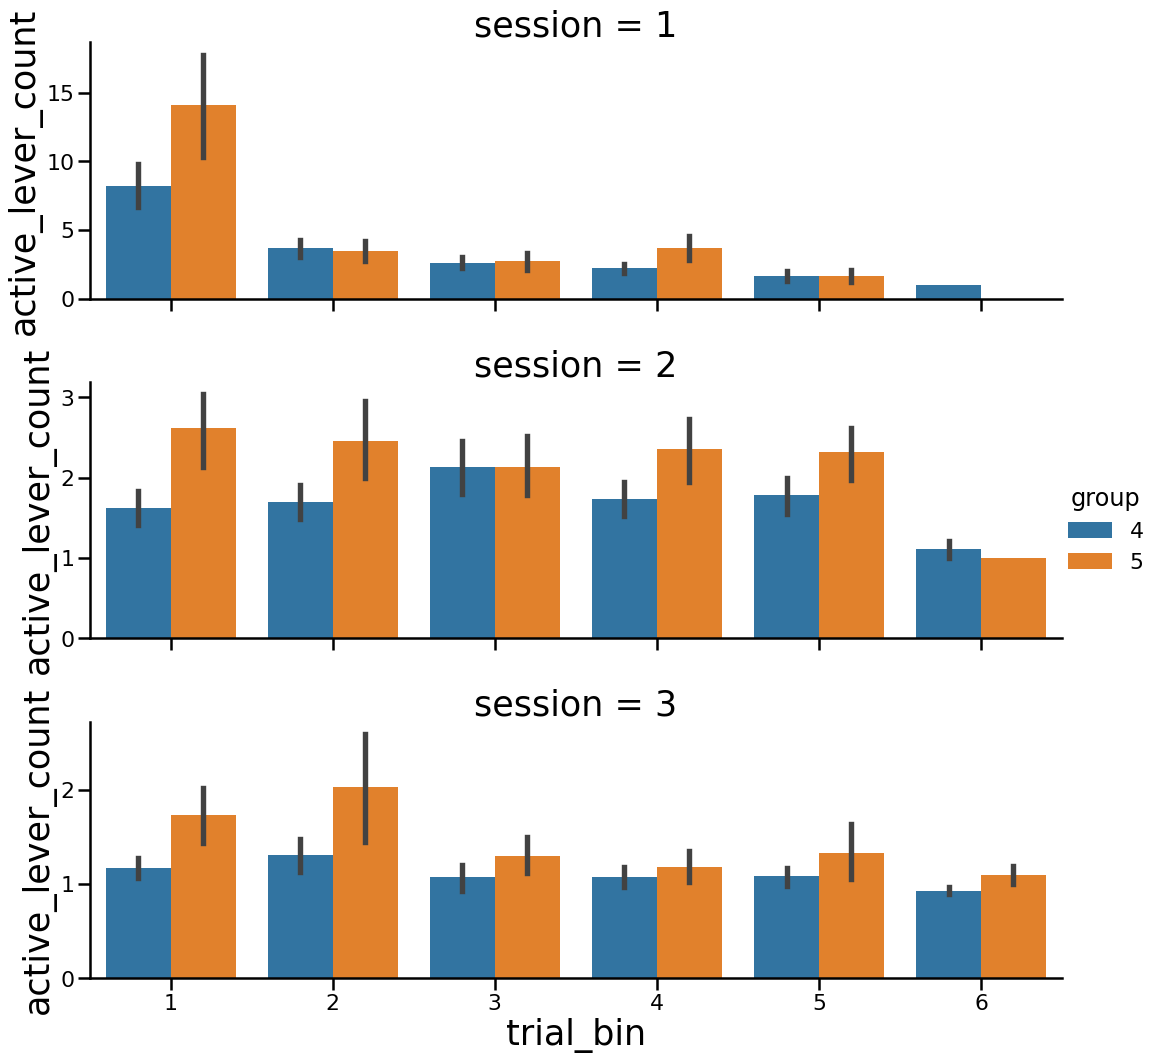

In [49]:
data_int = lp_train_df_trial[lp_train_df_trial['part'] == 'within']
data_int = data_int[data_int['animal'] != 1230]
sns.catplot(x='trial_bin', y='active_lever_count', data=data_int, kind='bar', ci=68, 
            hue='group', col='session', col_wrap=1, height=5, aspect=3, sharey=False) 

<AxesSubplot:xlabel='trial_num', ylabel='lever_ratio'>

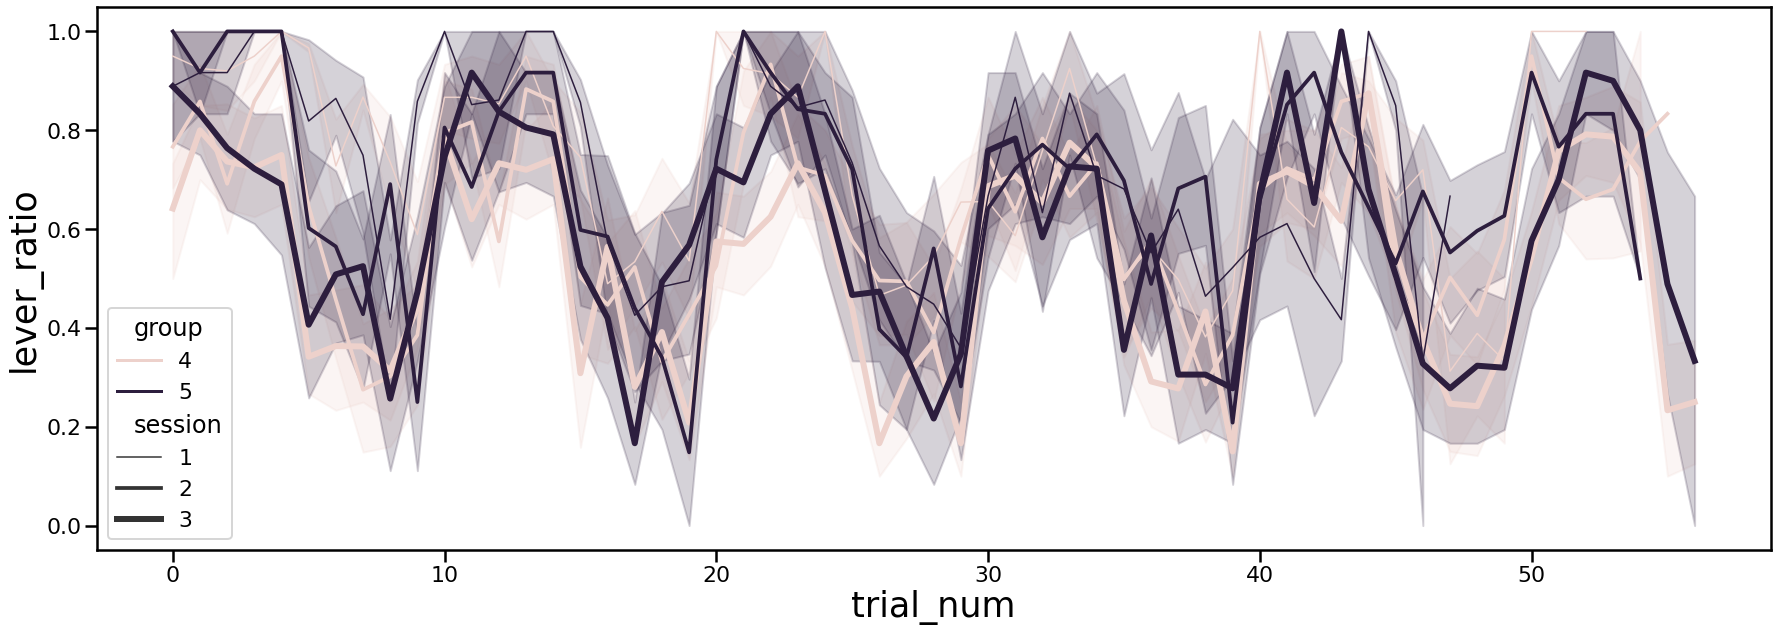

In [50]:
plt.figure(figsize=(30,10))
sns.lineplot(x='trial_num', y='lever_ratio', data=data_int, ci=68, 
            hue='group', size='session') 

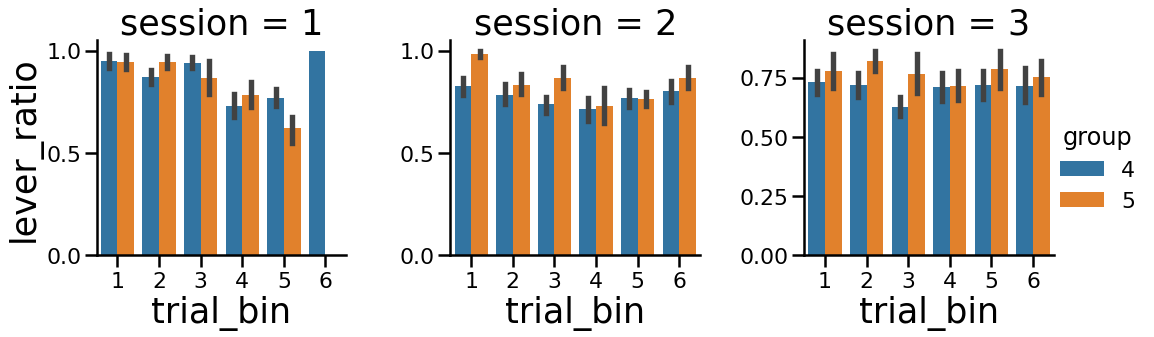

In [71]:
data_int_orig = data_int[data_int['switch'] == 'orig']

data_int_sum = data_int_orig.groupby(['session', 'trial_bin', 'group', 'animal'])['lever_ratio'].mean().reset_index()
sns.catplot(x='trial_bin', y='lever_ratio', data=data_int_sum, kind='bar', ci=68, 
            hue='group', col='session', height=5, aspect=1, sharey=False) 

In [67]:
data_int_sum

,session,trial_bin,group,animal,active_lever_count
0,1,1,4,1218,5
1,1,1,4,1219,5
2,1,1,4,1224,5
3,1,1,4,1225,5
4,1,1,4,1226,5
5,1,1,4,1227,5
6,1,1,4,1228,5
7,1,1,4,1229,5
8,1,1,4,1231,5
9,1,1,4,1232,5


In [ ]:
lp_train_df_trial.to_csv('LPD.csv', index=False)

### Single for ts

In [ ]:
file_path = file_paths[0]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info_common(file_path)
print('date:', date, 'animal:', animal, 'task:', task, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E:", "T:")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_LPDS(events_and_times, 10,12,6,7,100)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times, 'within')
print(trial_data.head(), '\n')

ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_trial_data.head(), '\n')

bit_dic = {'reinforcement': 4, 'right_lever': 1, 'left_lever': 2, 'HE': 3}
session_data = create_session_df_LPDS(trial_data, bit_dic, 'within')

ITI_dic = {'reinforcement': 4, 'right_lever': 1, 'left_lever': 2, 'HE': 3}
ITI_data = create_session_df_LPDS(ITI_trial_data, ITI_dic, 'ITI')